In [1]:
import os,sys,math
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import tensorflow as tf
%matplotlib inline

In [13]:
# download of MNIST data
if(not os.path.exists('train-images-idx3-ubyte.gz')):
    os.system('wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')
    os.system('wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')
    os.system('wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')
    os.system('wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz')
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./", one_hot=True)

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz


In [3]:
def showP(d, f, n=None):
    if(n==None):
        R = 1
    else:
        R = n
    for i in range(R):
        if(i%10==0):
            N = R-i
            if(N > 10): N = 10
            fig, axs = plt.subplots(1, N)
        I = i + f
        im = np.asarray(d.images[I]).reshape(28,28)
        try:
            ax = axs[i%N]
        except:
            ax = axs
        ax.imshow(im)
        label =  d.labels[I].argmax()
        ax.set_title(label)

def f2q(d, Q):
    '''To convert a number from floating point to Qm.n format:
        1. Multiply the floating point number by 2n
        2. Round to the nearest integer
    '''
    if(type(d) is list):
        D = []
        for v in d:
            D.append(int(v*math.pow(2,Q)+0.5))
    elif(type(d) is np.ndarray):
        D = int(d*math.pow(2,Q)+0.5)
    else:
        D = int(d*math.pow(2,Q)+0.5)
    return D

def ToList(d):
    sz=1
    for s in d.shape:
        sz = sz*s
    return d.reshape(sz).tolist()

def q2f(d, Q):
    '''To convert a number from Qm.n format to floating point:
        1. Convert the number to floating point as if it were an integer, in other words remove the binary point
        2. Multiply by 2−n
    '''
    if(type(d) is np.ndarray):
        d = ToList(d)
    if(type(d) is list):
        D = []
        for v in d:
            D.append(float(v*math.pow(2,-Q)))
    elif(type(d) is np.ndarray):
        D = d*math.pow(2,-Q)
    else:
        D = float(d*math.pow(2,-Q))
    return D
def save(w,name):
    if(type(w) is np.ndarray):
        aL = ToList(w)
    else:
        aL = list(w)
    MIN,MAX=min(aL),max(aL)
    Q = int(np.ceil(np.log2(max(abs(MIN),abs(MAX)))))
    Q = 7-Q
    qL = np.asarray(f2q(aL,Q),np.int8)
    qL.tofile('tmp/%s_%s.raw'%(name,Q))

def showW(w, name):
    if(type(w) is np.ndarray):
        aL = ToList(w)
    else:
        aL = list(w)
    MIN,MAX=min(aL),max(aL)
    Q = int(np.ceil(np.log2(max(abs(MIN),abs(MAX)))))
    Q = 7-Q
    qL = np.asarray(f2q(aL,Q),np.int8)
    qL = q2f(ToList(qL),Q)
    plt.figure(figsize=(18, 3))  
    plt.subplot(131)
    plt.title(name)
    plt.plot(aL)
    plt.grid()
    aL.sort()
    plt.plot(aL,'r')
    plt.grid()
    plt.subplot(132)
    plt.title('Q%s'%(Q))
    qL.sort()
    plt.plot(aL,'r')
    plt.plot(qL,'g')
    plt.grid()
    plt.subplot(133)
    plt.hist(aL,100)
    plt.title('hist')
    plt.grid()
    plt.show()

def show(a1, a2=None, a3=None):
    if(type(a2) == str):
        showW(a1, a2)
    else:
        showP(a1, a2, a3)


def compare(a,b,name):
    if(type(a) is np.ndarray):
        aL = ToList(a)
    else:
        aL = list(a)
    if(type(b) is np.ndarray):
        bL = ToList(b)
    else:
        bL = list(b)
    assert(len(aL) == len(bL))
    Z = list(zip(aL,bL))
    Z.sort(key=lambda x: x[0])
    aL1,bL1=zip(*Z)
    plt.figure(figsize=(18, 3))
    plt.subplot(131)
    plt.plot(aL)
    plt.plot(aL1,'r')
    plt.grid()
    plt.title('tf-%s'%(name))
    plt.subplot(133)
    plt.plot(bL1,'g')
    plt.plot(aL1,'r')
    plt.grid()
    plt.title('compare')
    plt.subplot(132)
    bL1=list(bL1)
    bL1.sort()
    plt.plot(bL)
    plt.plot(bL1,'g')
    plt.grid()
    plt.title('nn-%s'%(name))

In [4]:
# according to http://www.tensorfly.cn/tfdoc/tutorials/mnist_pros.html
def weight_variable(shape, name):
  initial = tf.truncated_normal(shape, stddev=0.1, name=name+'_initial')
  return tf.Variable(initial, name=name)

def bias_variable(shape, name):
  initial = tf.constant(0.1, shape=shape, name=name+'_initial')
  return tf.Variable(initial, name=name)

def conv2d(x, W, name):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME', name=name)

def max_pool_2x2(x, name):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME', name=name)
def model(sess,mnist):
    x = tf.placeholder(tf.float32, [None, 784], name='x')
    y_ = tf.placeholder(tf.float32, [None, 10], name='y_')
    W_conv1 = weight_variable([5, 5, 1, 32], name='W_conv1')
    b_conv1 = bias_variable([32], name='b_conv1')
    x_image = tf.reshape(x, [-1,28,28,1], name='x_image')
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, name='conv2d1') + b_conv1, name='h_conv1')
    h_pool1 = max_pool_2x2(h_conv1, name='h_pool1')
    W_conv2 = weight_variable([5, 5, 32, 64], name='W_conv2')
    b_conv2 = bias_variable([64], name='b_conv2')

    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2, name='conv2d2') + b_conv2, name='h_conv2')
    h_pool2 = max_pool_2x2(h_conv2, name='h_pool2')
    W_fc1 = weight_variable([7 * 7 * 64, 1024], name='W_fc1')
    b_fc1 = bias_variable([1024], name='b_fc1')

    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64], name='h_pool2_flat')
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1, name='h_fc1')
    W_fc2 = weight_variable([1024, 10], name='W_fc2')
    b_fc2 = bias_variable([10], name='b_fc2')

    y=tf.nn.softmax(tf.matmul(h_fc1, W_fc2) + b_fc2, name='y')
    cross_entropy = -tf.reduce_sum(y_*tf.log(y))
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    sess.run(tf.global_variables_initializer())
    for i in range(2000):
        batch_xs, batch_ys = mnist.train.next_batch(100)
        train_step.run(feed_dict={x: batch_xs, y_: batch_ys})
        if(i%200 == 0):
            train_accuracy = accuracy.eval(feed_dict={x:batch_xs, y_: batch_ys})
            print("step %d, training accuracy %g"%(i, train_accuracy))
    return x,y

def load(sess, model):
    with tf.gfile.FastGFile(model, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name='')
    
    x = sess.graph.get_tensor_by_name('x:0')
    y = sess.graph.get_tensor_by_name('y:0')
    sess.run(tf.global_variables_initializer())
    return x,y

def RunSysCmd(cmd):
    import subprocess
    p = subprocess.Popen(cmd, stdout=subprocess.PIPE, shell=True)
    (output, err) = p.communicate()
    p_status = p.wait()
    print(output.decode('utf-8'))

In [5]:
sess = tf.InteractiveSession()

In [6]:
if(os.path.exists('./mnist.pb')):
    x,y = load(sess, './mnist.pb')
else:
    x,y = model(sess,mnist)
    from tensorflow.python.framework import graph_util
    constant_graph = graph_util.convert_variables_to_constants(sess, sess.graph_def, ['y'])
    with tf.gfile.FastGFile('./mnist.pb', mode='wb') as f:
        f.write(constant_graph.SerializeToString())

Instructions for updating:
Use tf.gfile.GFile.


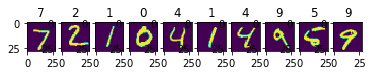

In [7]:
show(mnist.test, 0,10)

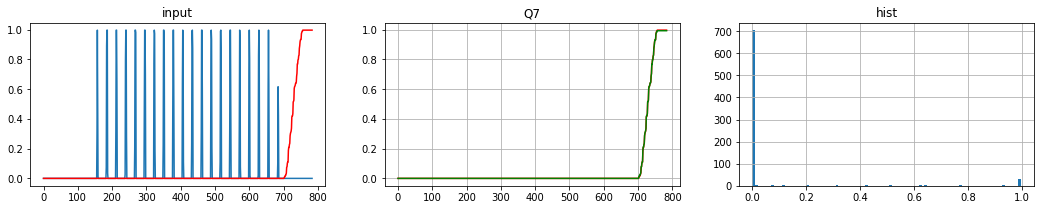

[2.0579378e-06 9.9857819e-01 1.0433692e-05 1.6595877e-05 2.3442999e-04
 1.1268570e-06 1.0411537e-05 1.1290240e-03 1.6024018e-05 1.9479444e-06] 1 1.00


In [8]:
index = 5
X = mnist.test.images[index:index+1]
a = sess.run(y, feed_dict={x: X})[0]
show(mnist.test.images[index],'input')
print(a, a.argmax(), '%.2f'%a[a.argmax()])

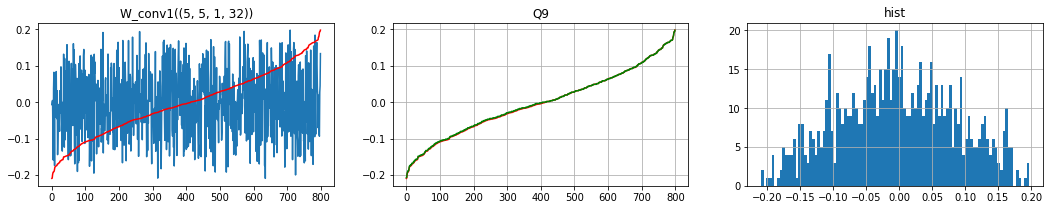

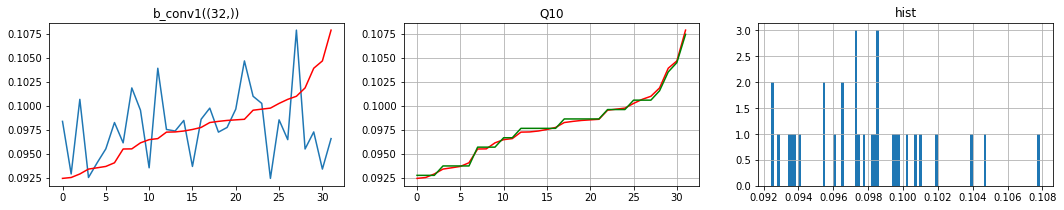

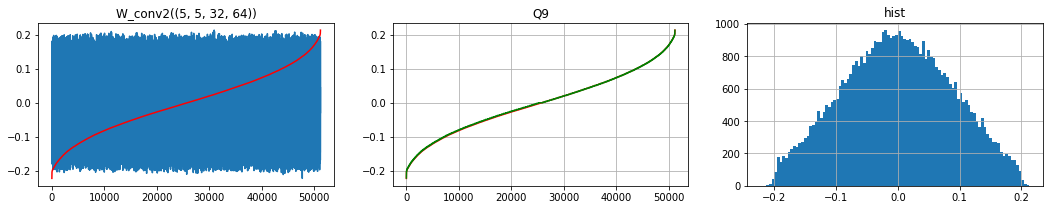

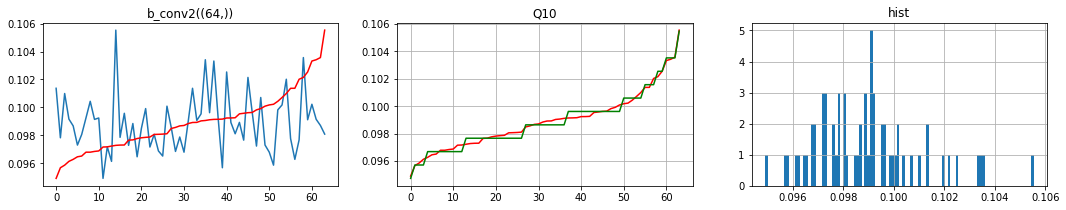

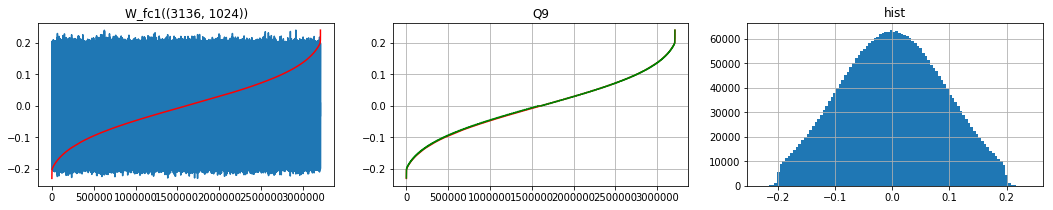

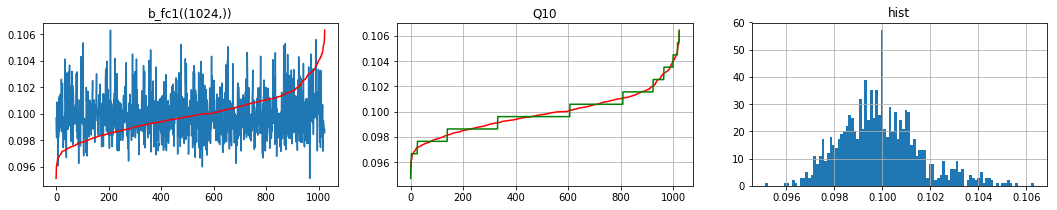

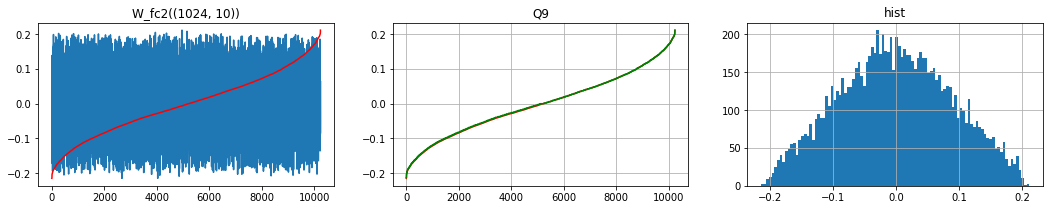

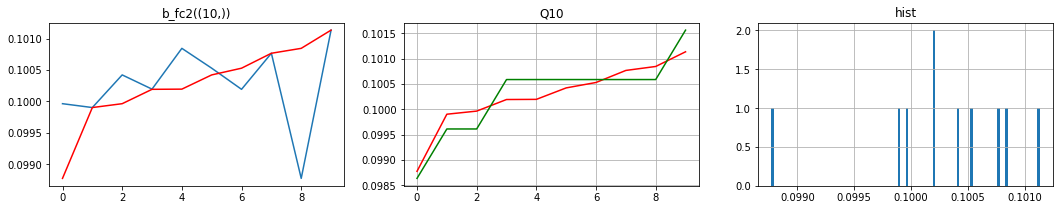

In [9]:
if(not os.path.exists('tmp')): os.mkdir('tmp')
save(X[0],'input')
for i,node in enumerate(sess.graph_def.node):
    if((node.op == 'Const') and ('shape' not in node.name)):
        me = sess.graph.get_tensor_by_name('%s:0'%(node.name))
        wt = me.eval()
        show(wt, '%s(%s)'%(node.name,me.shape))
        if(len(me.shape)==4):
            wt = wt.transpose(3, 0, 1, 2)
        save(wt,node.name)

In [10]:
tf.summary.FileWriter('./graphs', sess.graph)
# and run : $ tensorboard --logdir="./graphs"

In [11]:
RunSysCmd('scons')
RunSysCmd('./mnist')

scons: Reading SConscript files ...
scons: done reading SConscript files.
scons: Building targets ...
CC /home/parai/workspace/as/release/download/CMSIS_5/CMSIS/NN/Source/ConvolutionFunctions/arm_convolve_HWC_q7_RGB.c
LINK mnist
scons: done building targets.

loading input&weights...
inference is done!



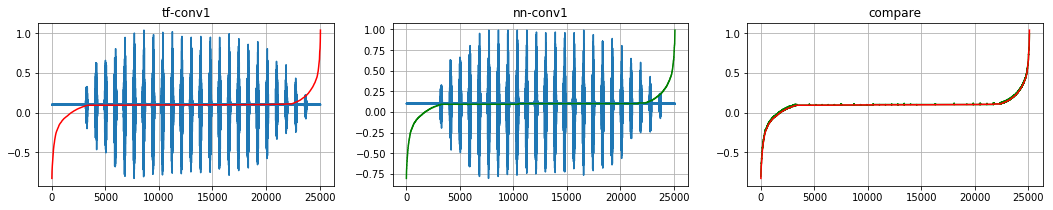

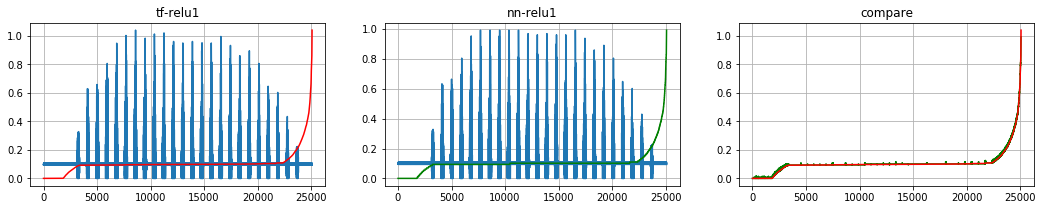

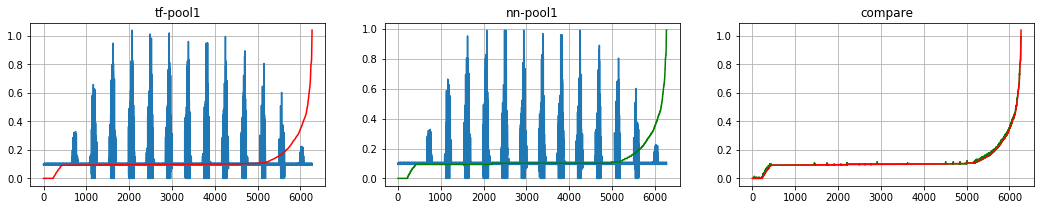

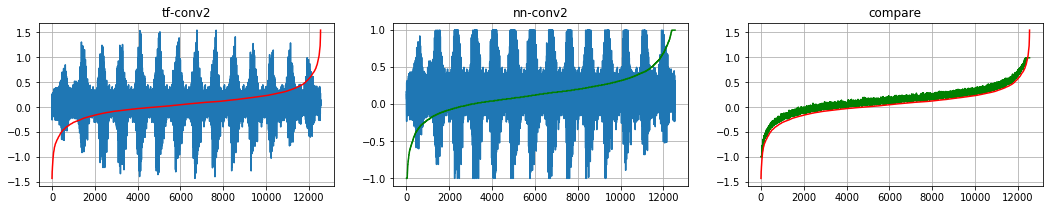

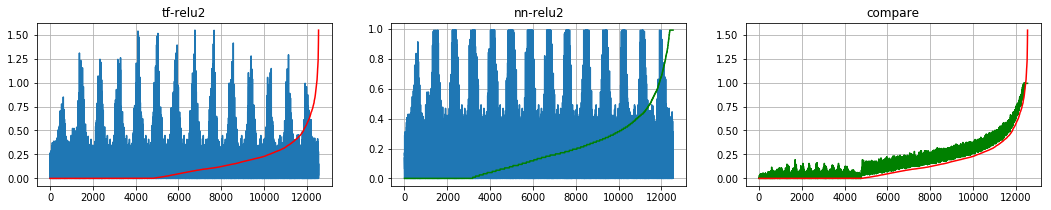

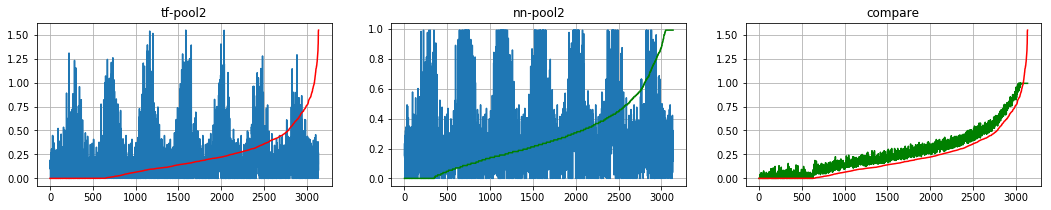

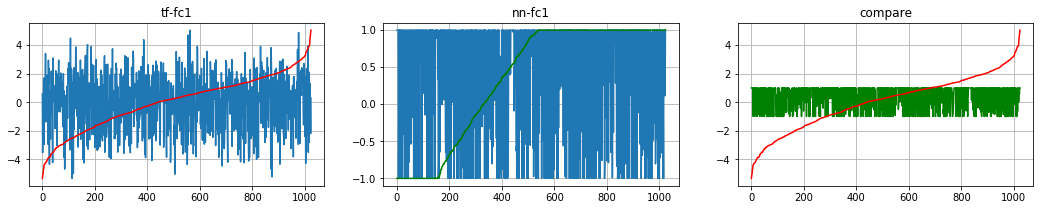

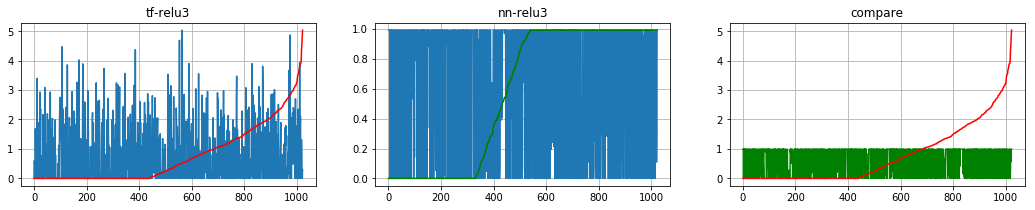

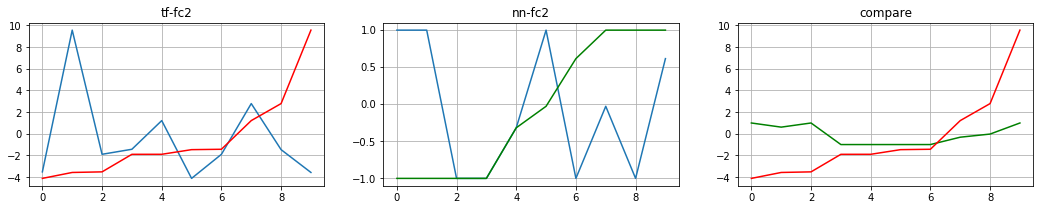

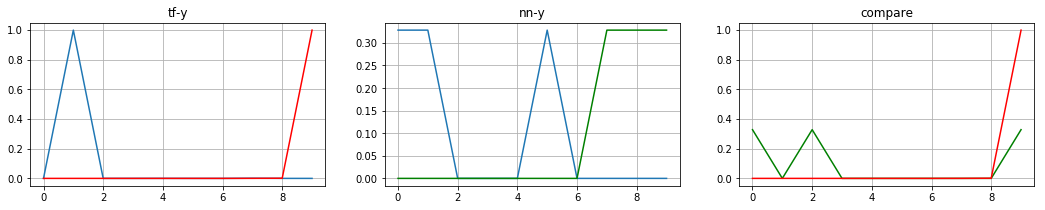

In [12]:
for nnL, tfL in [('conv1','add'),   ('relu1','h_conv1'), ('pool1','h_pool1'), 
                 ('conv2','add_1'), ('relu2','h_conv2'), ('pool2','h_pool2'),
                 ('fc1','add_2'),   ('relu3','h_fc1'),   ('fc2','add_3'),
                 ('y','y')]:
    out = q2f(np.fromfile('tmp/%s_out.raw'%(nnL),dtype=np.int8),7)
    outR = sess.run(sess.graph.get_tensor_by_name('%s:0'%(tfL)), feed_dict={x: X})[0]
    compare(outR,out,nnL)